**5)	[Mining publicly available data] Download the dataset on car evaluations from http://archive.ics.uci.edu/ml/datasets/Car+Evaluation (this link also has the description of the data). This dataset has 1728 records, each record representing a car evaluation. Each car evaluation is described with 7 attributes. 6 of the attributes represent car characteristics, such as buying price, price of the maintenance, number of doors, capacity in terms of persons to carry, the size of luggage boot, and estimated safety of the car. The seventh variable represents the evaluation of the car (unacceptable, acceptable, good, very good).**

**Your task: Among the basic classification techniques that you are familiar with (i.e., decision tree, k-NN, logistic regression, NB, SVM) use all that would be applicable to this dataset to predict the evaluation of the cars based on their characteristics. Explore how well these techniques perform for several different parameter values. Present a brief overview of your predictive modeling process, explorations, and discuss your results. Present your final model (i.e., the best predictive model that you were able to come up with), and discuss its performance in a comprehensive manner (overall accuracy; per-class performance, i.e., whether this model predicts all classes equally well, or if there some classes for which it does much better than others; etc.).**

**Note that in this classification problem your input variables are ordinal. Should you treat them as numeric or categorical? (What are pros and cons?) You can try building your models both ways; which demonstrate better predictive performance?**


In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.datasets import make_classification
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
from sklearn.datasets import load_breast_cancer
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, make_scorer
from sklearn.preprocessing import LabelEncoder

In [4]:
##loading the data
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'evaluation']
car_data = pd.read_csv(r'C:\Users\amubi\Desktop\MSBA_Class\Fall\MSBA 6421 Predictive\HW2\car.data', header=None, names=column_names)
car_data.head()

,buying,maint,doors,persons,lug_boot,safety,evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   buying      1728 non-null   object
 1   maint       1728 non-null   object
 2   doors       1728 non-null   object
 3   persons     1728 non-null   object
 4   lug_boot    1728 non-null   object
 5   safety      1728 non-null   object
 6   evaluation  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [8]:
car_data.describe().T

,count,unique,top,freq
buying,1728,4,vhigh,432
maint,1728,4,vhigh,432
doors,1728,4,2,432
persons,1728,3,2,576
lug_boot,1728,3,small,576
safety,1728,3,low,576
evaluation,1728,4,unacc,1210


In [10]:
# Checking distribution of  features
for column in column_names:
    print(car_data[column].value_counts())
#All features are categorical in nature

vhigh    432
high     432
med      432
low      432
Name: buying, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: maint, dtype: int64
2        432
3        432
4        432
5more    432
Name: doors, dtype: int64
2       576
4       576
more    576
Name: persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: evaluation, dtype: int64


In [11]:
car_data.isna().sum()

buying        0
maint         0
doors         0
persons       0
lug_boot      0
safety        0
evaluation    0
dtype: int64

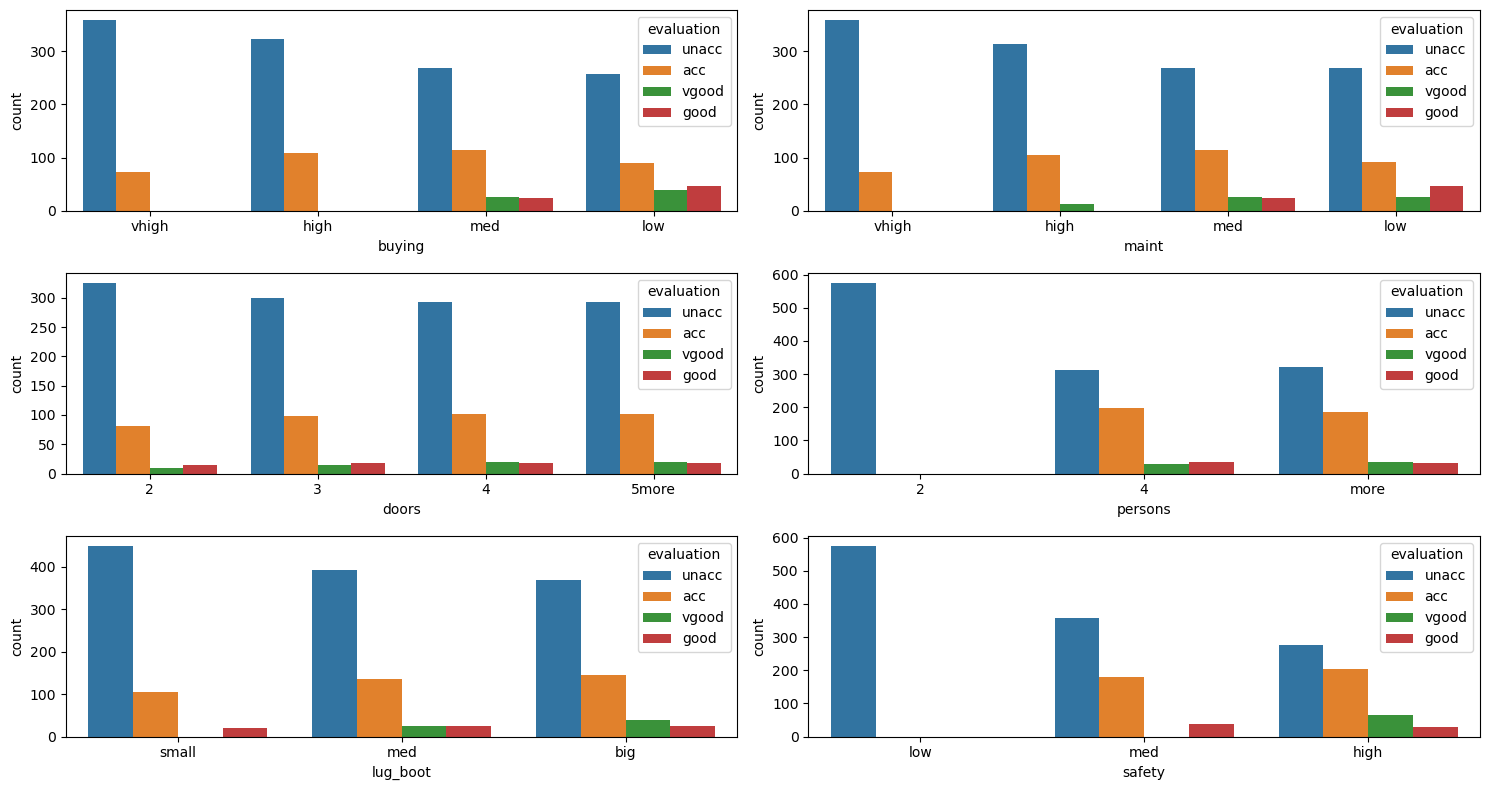

In [15]:
# Visualizing the feature from evaluation perspective
col_name=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
i=1
plt.figure(figsize=(15,8))
for col in col_name:
    plt.subplot(3,2,i)
    sns.countplot(data=car_data,x=col,hue='evaluation')
    i=i+1
plt.tight_layout()

**Converting the input data to numerical through one-hot encoding**

In [16]:
## comverting the categorical variables to numerical values through one-hot encoding
df_one_hot = pd.get_dummies(car_data, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'evaluation'])
df_one_hot.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med,evaluation_acc,evaluation_good,evaluation_unacc,evaluation_vgood
0,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,1,0,0,1,0
2,0,0,0,1,0,0,0,1,1,0,...,0,0,1,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0


In [19]:
# df_one_hot is your one-hot encoded DataFrame
X = df_one_hot.drop(['evaluation_unacc', 'evaluation_acc', 'evaluation_good', 'evaluation_vgood'], axis=1)
y = df_one_hot[['evaluation_unacc', 'evaluation_acc', 'evaluation_good', 'evaluation_vgood']]

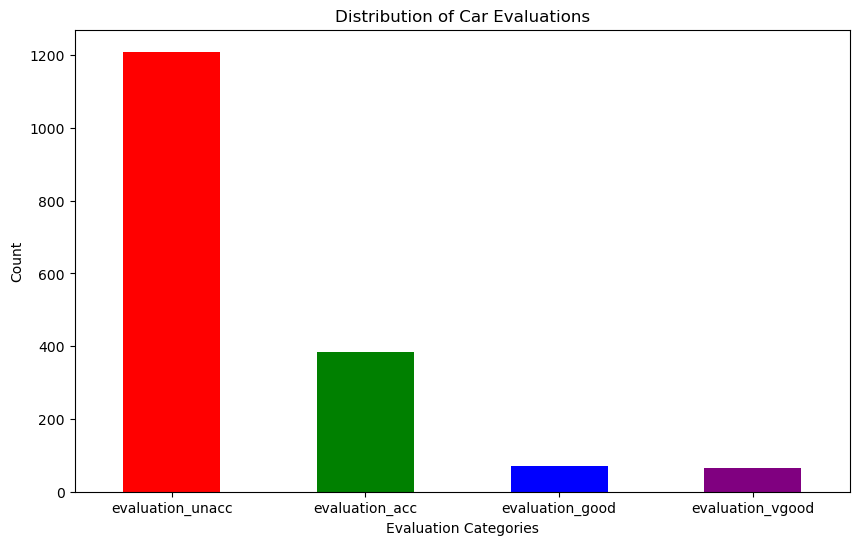

In [20]:
# Sum up the occurrences of each category
category_sums = y.sum()

# Create the bar plot
plt.figure(figsize=(10, 6))
category_sums.plot(kind='bar', color=['red', 'green', 'blue', 'purple'])
plt.xlabel('Evaluation Categories')
plt.ylabel('Count')
plt.title('Distribution of Car Evaluations')
plt.xticks(rotation=0)
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=45)

In [31]:
# Number of random trials
NUM_TRIALS = 10

# Set up possible values of parameters to optimize over
dt_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a pipeline with Standard Scaler and Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale the data
    ('classifier', LogisticRegression(max_iter=1000, solver='saga'))  # Step 2: Apply Logistic Regression
])


lr_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [1000],  # Added max_iter to the grid
    'classifier__solver': ['newton-cg', 'saga']  # Added solver to the grid
}

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
knn_metric = ["euclidean", "manhattan"]

knn_grid = dict(n_neighbors = k_range, weights = weight_options, metric = knn_metric)

# Hyperparameter grid for SVM
svm_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__degree': [2, 3, 4, 5],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__coef0': [0, 1, 2, 3]
}

# Create a pipeline with Standard Scaler and SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

nb_grid = {}

# Defining the classifier to be used
dt = tree.DecisionTreeClassifier()
knn = KNeighborsClassifier()
nb = GaussianNB()


# Arrays to store scores
dt_scores = np.zeros(NUM_TRIALS)
lr_scores = np.zeros(NUM_TRIALS)
knn_scores = np.zeros(NUM_TRIALS)
svm_scores = np.zeros(NUM_TRIALS)
nb_scores = np.zeros(NUM_TRIALS)

best_params = {}
y_train_label_encoded = np.argmax(y_train.values, axis=1)
y_train_label_encoded[:5]

array([1, 1, 0, 0, 1], dtype=int64)

In [32]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

#Loop for each trial
#Chose cross validation techniques for the inner and outer loops, independantly of the dataset
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    scoring = 'accuracy'
    # Non_nested parameter search and scoring
    dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = scoring, cv=inner_cv)
    lr_clf = GridSearchCV(estimator=pipeline_lr, param_grid=lr_grid, scoring = scoring, cv=inner_cv)
    knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = scoring, cv=inner_cv)
    svm_clf = GridSearchCV(estimator=pipeline_svm, param_grid=svm_grid, scoring = scoring, cv=inner_cv)
    nb_clf = GridSearchCV(estimator=nb, param_grid=nb_grid, scoring=scoring, cv=inner_cv)
    
    # Nested CV with parameter optimization
    dt_score = cross_val_score(dt_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    dt_scores[i] = dt_score.mean()
    lr_score = cross_val_score(lr_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    lr_scores[i] = lr_score.mean()
    knn_score = cross_val_score(knn_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    knn_scores[i] = knn_score.mean()
    svm_score = cross_val_score(svm_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    svm_scores[i] = svm_score.mean()
    nb_score = cross_val_score(nb_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    nb_scores[i] = nb_score.mean()
      
    print(f"Trial {i+1}")
    print(f"Decision Tree Accuracy: {dt_scores[i]}")
    print(f"Logistic Regression Accuracy: {lr_scores[i]}")
    print(f"k-NN Accuracy: {knn_scores[i]}")
    print(f"SVM Accuracy: {svm_scores[i]}")
    print(f"Naive Bayes Accuracy: {nb_scores[i]}")
    print("-------------------------------")

# Calculate mean scores across all trials
mean_dt_score = np.mean(dt_scores)
mean_lr_score = np.mean(lr_scores)
mean_knn_score = np.mean(knn_scores)
mean_svm_score = np.mean(svm_scores)
mean_nb_score = np.mean(nb_scores)

# Find the best model based on mean score
best_model_score = np.max([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score, mean_nb_score])
model_names = ["Decision Tree", "Logistic Regression", "k-NN", "SVM","Naive Bayes"]
best_model_index = np.argmax([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score, mean_nb_score])
best_model_name = model_names[best_model_index]



Trial 1
Decision Tree Accuracy: 0.965258855585831
Logistic Regression Accuracy: 0.9359673024523161
k-NN Accuracy: 0.8903269754768391
SVM Accuracy: 0.9959128065395095
Naive Bayes Accuracy: 0.805858310626703
-------------------------------
Trial 2
Decision Tree Accuracy: 0.9693460490463215
Logistic Regression Accuracy: 0.9298365122615804
k-NN Accuracy: 0.8896457765667576
SVM Accuracy: 0.9931880108991825
Naive Bayes Accuracy: 0.8058583106267029
-------------------------------
Trial 3
Decision Tree Accuracy: 0.9632152588555859
Logistic Regression Accuracy: 0.9298365122615804
k-NN Accuracy: 0.8828337874659401
SVM Accuracy: 0.9938692098092644
Naive Bayes Accuracy: 0.805858310626703
-------------------------------
Trial 4
Decision Tree Accuracy: 0.9747956403269755
Logistic Regression Accuracy: 0.9318801089918256
k-NN Accuracy: 0.8916893732970027
SVM Accuracy: 0.9972752043596731
Naive Bayes Accuracy: 0.805858310626703
-------------------------------
Trial 5
Decision Tree Accuracy: 0.9700272479

ValueError: 
All the 2048 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2048 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amubi\anaconda3\anaconda4\envs\homl3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amubi\anaconda3\anaconda4\envs\homl3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\amubi\anaconda3\anaconda4\envs\homl3\lib\site-packages\sklearn\svm\_base.py", line 173, in fit
    X, y = self._validate_data(
  File "C:\Users\amubi\anaconda3\anaconda4\envs\homl3\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\amubi\anaconda3\anaconda4\envs\homl3\lib\site-packages\sklearn\utils\validation.py", line 1090, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "C:\Users\amubi\anaconda3\anaconda4\envs\homl3\lib\site-packages\sklearn\utils\validation.py", line 1111, in _check_y
    y = column_or_1d(y, warn=True)
  File "C:\Users\amubi\anaconda3\anaconda4\envs\homl3\lib\site-packages\sklearn\utils\validation.py", line 1156, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1101, 4) instead.


In [33]:
#Corrected the error in this cell, 
#rerunning the nested CV will take lot of time 
# and hence I have let the errors as it is
#PLEASE IGNORE THE ERROR above
#Extract best parameters for the best model
if best_model_name == "Decision Tree":
    dt_clf.fit(X_train, y_train_label_encoded)
    best_params = dt_clf.best_params_
elif best_model_name == "Logistic Regression":
    lr_clf.fit(X_train, y_train_label_encoded)
    best_params = lr_clf.best_params_
elif best_model_name == "k-NN":
    knn_clf.fit(X_train, y_train_label_encoded)
    best_params = knn_clf.best_params_
elif best_model_name == "SVM":
    svm_clf.fit(X_train, y_train_label_encoded)
    best_params = svm_clf.best_params_
elif best_model_name == "Naive Bayes":
    nb_clf.fit(X_train, y_train_label_encoded)
    best_params = nb_clf.best_params_

print(f"Best Model: {best_model_name} with mean score {best_model_score}")
print(f"Best Parameters: {best_params}")

Best Model: SVM with mean score 0.9951634877384196
Best Parameters: {'classifier__C': 1, 'classifier__coef0': 1, 'classifier__degree': 5, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}


Confusion Matrix:
[[191   0   1   0]
 [  0  47   0   0]
 [  0   0  10   0]
 [  0   0   0  11]]

Predictive Accuracy: 99.62%

Classification Error: 0.38%

Classification Report (Precision, Recall, F-measure):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       192
           1       1.00      1.00      1.00        47
           2       0.91      1.00      0.95        10
           3       1.00      1.00      1.00        11

    accuracy                           1.00       260
   macro avg       0.98      1.00      0.99       260
weighted avg       1.00      1.00      1.00       260



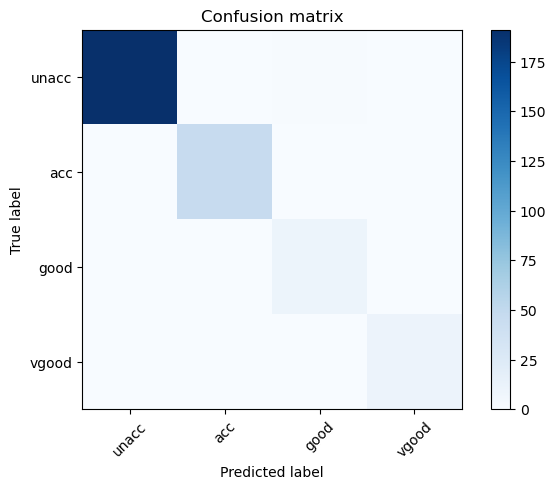

In [34]:
y_test_label_encoded = np.argmax(y_test.values, axis=1)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(['unacc', 'acc', 'good', 'vgood']))
    plt.xticks(tick_marks, ['unacc', 'acc', 'good', 'vgood'], rotation=45)
    plt.yticks(tick_marks, ['unacc', 'acc', 'good', 'vgood'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict labels for test data
best_svm_clf = svm_clf.best_estimator_
y_pred = best_svm_clf.predict(X_test)


# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test_label_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure()
plot_confusion_matrix(conf_matrix)

# Calculate and display the predictive accuracy
accuracy = accuracy_score(y_test_label_encoded, y_pred)
print(f"\nPredictive Accuracy: {accuracy*100:.2f}%")

# Calculate and display classification error
classification_error = 1 - accuracy
print(f"\nClassification Error: {classification_error*100:.2f}%")

# Calculate and display precision, recall, and f-measure
print("\nClassification Report (Precision, Recall, F-measure):")
print(classification_report(y_test_label_encoded, y_pred))

The overall predictive accuracy of your model is 99.62%, which is exceptionally high. This means that the model correctly classified approximately 99.62% of the test instances.

**Per-Class Performance**
To understand the per-class performance, we look at the confusion matrix and the classification report, which includes precision, recall, and F1-score for each class.

The confusion matrix shows that:

For class 0 ('unacc'), 191 out of 192 instances were correctly classified.
For class 1 ('acc'), all 47 instances were correctly classified.
For class 2 ('good'), all 10 instances were correctly classified.
For class 3 ('vgood'), all 11 instances were correctly classified.
**Precision, Recall, and F1-Score**
Class 0 ('unacc'): Precision = 1.00, Recall = 0.99, F1-Score = 1.00
Class 1 ('acc'): Precision = 1.00, Recall = 1.00, F1-Score = 1.00
Class 2 ('good'): Precision = 0.91, Recall = 1.00, F1-Score = 0.95
Class 3 ('vgood'): Precision = 1.00, Recall = 1.00, F1-Score = 1.00

Overall Accuracy: The model performs extremely well with an overall accuracy of **99.62%**.

**Per-Class Performance:** The model is consistent in its performance across different classes. It performs exceptionally well for classes 'unacc', 'acc', and 'vgood' with perfect or near-perfect precision, recall, and F1-scores. For class 'good', the model has a slightly lower precision of 0.91 but a perfect recall of 1.00, indicating that it is slightly more conservative in predicting this class but when it does, it's accurate.

**Class Imbalance:** It's worth noting that the classes are not equally represented. For example, class 0 ('unacc') has many more instances than class 2 ('good') or class 3 ('vgood'). Despite this imbalance, the model performs well across all classes, which is a good sign.

**Converting the categorical data into ordinal data**

In [38]:
# Ordinal Encoding
import category_encoders as ce

In [42]:
X = car_data.iloc[:, :6]
y = car_data['evaluation']
# cols -- is pre-define variable 
encoder=ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
X=encoder.fit_transform(X)
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,1,1,1,1,1,1
1,1,1,1,1,1,2
2,1,1,1,1,1,3
3,1,1,1,1,2,1
4,1,1,1,1,2,2


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=45)

In [46]:
# Number of random trials
NUM_TRIALS = 10

# Set up possible values of parameters to optimize over
dt_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a pipeline with Standard Scaler and Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale the data
    ('classifier', LogisticRegression(max_iter=1000, solver='saga'))  # Step 2: Apply Logistic Regression
])


lr_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [1000],  # Added max_iter to the grid
    'classifier__solver': ['newton-cg', 'saga']  # Added solver to the grid
}

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
knn_metric = ["euclidean", "manhattan"]

knn_grid = dict(n_neighbors = k_range, weights = weight_options, metric = knn_metric)

# Hyperparameter grid for SVM
svm_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__degree': [2, 3, 4, 5],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__coef0': [0, 1, 2, 3]
}

# Create a pipeline with Standard Scaler and SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

nb_grid = {}

# Defining the classifier to be used
dt = tree.DecisionTreeClassifier()
knn = KNeighborsClassifier()
nb = GaussianNB()


# Arrays to store scores
dt_scores = np.zeros(NUM_TRIALS)
lr_scores = np.zeros(NUM_TRIALS)
knn_scores = np.zeros(NUM_TRIALS)
svm_scores = np.zeros(NUM_TRIALS)
nb_scores = np.zeros(NUM_TRIALS)

best_params = {}
label_encoder = LabelEncoder()
y_train_label_encoded = label_encoder.fit_transform(y_train)
y_train_label_encoded[:5]

array([0, 0, 2, 2, 0])

In [47]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

#Loop for each trial
#Chose cross validation techniques for the inner and outer loops, independantly of the dataset
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    scoring = 'accuracy'
    # Non_nested parameter search and scoring
    dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = scoring, cv=inner_cv)
    lr_clf = GridSearchCV(estimator=pipeline_lr, param_grid=lr_grid, scoring = scoring, cv=inner_cv)
    knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = scoring, cv=inner_cv)
    svm_clf = GridSearchCV(estimator=pipeline_svm, param_grid=svm_grid, scoring = scoring, cv=inner_cv)
    nb_clf = GridSearchCV(estimator=nb, param_grid=nb_grid, scoring=scoring, cv=inner_cv)
    
    # Nested CV with parameter optimization
    dt_score = cross_val_score(dt_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    dt_scores[i] = dt_score.mean()
    lr_score = cross_val_score(lr_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    lr_scores[i] = lr_score.mean()
    knn_score = cross_val_score(knn_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    knn_scores[i] = knn_score.mean()
    svm_score = cross_val_score(svm_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    svm_scores[i] = svm_score.mean()
    nb_score = cross_val_score(nb_clf, X=X_train, y=y_train_label_encoded, cv=outer_cv)
    nb_scores[i] = nb_score.mean()
      
    print(f"Trial {i+1}")
    print(f"Decision Tree Accuracy: {dt_scores[i]}")
    print(f"Logistic Regression Accuracy: {lr_scores[i]}")
    print(f"k-NN Accuracy: {knn_scores[i]}")
    print(f"SVM Accuracy: {svm_scores[i]}")
    print(f"Naive Bayes Accuracy: {nb_scores[i]}")
    print("-------------------------------")

# Calculate mean scores across all trials
mean_dt_score = np.mean(dt_scores)
mean_lr_score = np.mean(lr_scores)
mean_knn_score = np.mean(knn_scores)
mean_svm_score = np.mean(svm_scores)
mean_nb_score = np.mean(nb_scores)

# Find the best model based on mean score
best_model_score = np.max([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score, mean_nb_score])
model_names = ["Decision Tree", "Logistic Regression", "k-NN", "SVM","Naive Bayes"]
best_model_index = np.argmax([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score, mean_nb_score])
best_model_name = model_names[best_model_index]

Trial 1
Decision Tree Accuracy: 0.9734332425068121
Logistic Regression Accuracy: 0.8290190735694822
k-NN Accuracy: 0.9393732970027249
SVM Accuracy: 0.989100817438692
Naive Bayes Accuracy: 0.6900544959128065
-------------------------------
Trial 2
Decision Tree Accuracy: 0.973433242506812
Logistic Regression Accuracy: 0.8276566757493188
k-NN Accuracy: 0.9339237057220708
SVM Accuracy: 0.9802452316076294
Naive Bayes Accuracy: 0.6900544959128065
-------------------------------
Trial 3
Decision Tree Accuracy: 0.9727520435967303
Logistic Regression Accuracy: 0.8249318801089919
k-NN Accuracy: 0.9489100817438691
SVM Accuracy: 0.9863760217983651
Naive Bayes Accuracy: 0.6920980926430518
-------------------------------
Trial 4
Decision Tree Accuracy: 0.9768392370572208
Logistic Regression Accuracy: 0.8303814713896458
k-NN Accuracy: 0.9420980926430518
SVM Accuracy: 0.9897820163487738
Naive Bayes Accuracy: 0.6914168937329701
-------------------------------
Trial 5
Decision Tree Accuracy: 0.97275204

In [48]:
#Extract best parameters for the best model
if best_model_name == "Decision Tree":
    dt_clf.fit(X_train, y_train_label_encoded)
    best_params = dt_clf.best_params_
elif best_model_name == "Logistic Regression":
    lr_clf.fit(X_train, y_train_label_encoded)
    best_params = lr_clf.best_params_
elif best_model_name == "k-NN":
    knn_clf.fit(X_train, y_train_label_encoded)
    best_params = knn_clf.best_params_
elif best_model_name == "SVM":
    svm_clf.fit(X_train, y_train_label_encoded)
    best_params = svm_clf.best_params_
elif best_model_name == "Naive Bayes":
    nb_clf.fit(X_train, y_train_label_encoded)
    best_params = nb_clf.best_params_

print(f"Best Model: {best_model_name} with mean score {best_model_score}")
print(f"Best Parameters: {best_params}")

Best Model: SVM with mean score 0.9842643051771116
Best Parameters: {'classifier__C': 10, 'classifier__coef0': 0, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


Confusion Matrix:
[[ 47   0   0   0]
 [  0  10   0   0]
 [  1   1 190   0]
 [  0   0   0  11]]

Predictive Accuracy: 99.23%

Classification Error: 0.77%

Classification Report (Precision, Recall, F-measure):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       0.91      1.00      0.95        10
           2       1.00      0.99      0.99       192
           3       1.00      1.00      1.00        11

    accuracy                           0.99       260
   macro avg       0.97      1.00      0.98       260
weighted avg       0.99      0.99      0.99       260



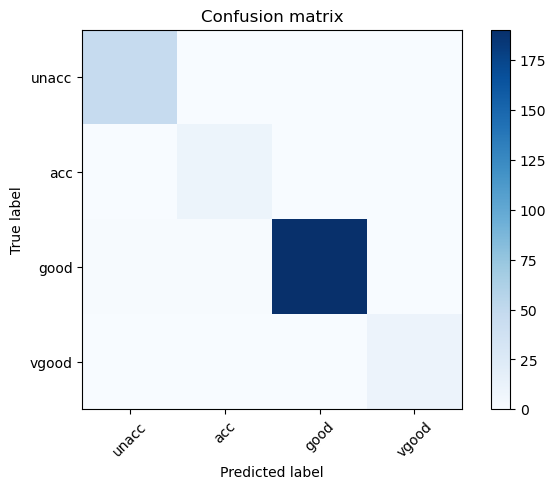

In [49]:
y_test_label_encoded = label_encoder.fit_transform(y_test)

# Predict labels for test data
best_svm_clf = svm_clf.best_estimator_
y_pred = best_svm_clf.predict(X_test)


# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test_label_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure()
plot_confusion_matrix(conf_matrix)

# Calculate and display the predictive accuracy
accuracy = accuracy_score(y_test_label_encoded, y_pred)
print(f"\nPredictive Accuracy: {accuracy*100:.2f}%")

# Calculate and display classification error
classification_error = 1 - accuracy
print(f"\nClassification Error: {classification_error*100:.2f}%")

# Calculate and display precision, recall, and f-measure
print("\nClassification Report (Precision, Recall, F-measure):")
print(classification_report(y_test_label_encoded, y_pred))

The confusion matrix shows the following:

Class 0: 47 True Positives, 0 False Negatives, 0 False Positives
Class 1: 10 True Positives, 0 False Negatives, 0 False Positives
Class 2: 190 True Positives, 1 False Negative, 1 False Positive
Class 3: 11 True Positives, 0 False Negatives, 0 False Positives

The overall predictive accuracy of the model is **99.23%**, which is extremely high. This suggests that the model is very effective at classifying the data into the correct categories.

**Per-Class Performance:**
Class 0: The model has a precision, recall, and F1-score of 0.98, 1.00, and 0.99 respectively. This indicates excellent performance for this class.

Class 1: The model has a precision, recall, and F1-score of 0.91, 1.00, and 0.95 respectively. While the recall is perfect, the precision is slightly lower compared to other classes, but still very high.

Class 2: The model has a precision, recall, and F1-score of 1.00, 0.99, and 0.99 respectively. This class has the highest number of samples and the model performs exceptionally well, with only one false negative and one false positive.

Class 3: The model has a precision, recall, and F1-score of 1.00, 1.00, and 1.00 respectively. This indicates perfect performance for this class, but it's worth noting that this class has the fewest samples.


Overall, the model performs exceptionally well across all classes, as indicated by the high accuracy and low classification error. The model is balanced in its predictive capability across different classes, as evidenced by the high precision, recall, and F1-scores for each class. This is a good indicator that the model is not biased towards any particular class.

However, Class 1 has a slightly lower precision compared to other classes, which might indicate a slightly higher false positive rate for this class. The model's performance on Class 2 and Class 0 is particularly noteworthy given that these classes have a higher number of samples. This suggests that the model is robust and not overfitting to smaller classes.

The perfect scores for Class 3 should be taken with a grain of caution due to the smaller sample size for this class. It's easier to get perfect scores when there are fewer samples to predict.

**Conclusion**

Better predictive performance was acheieved when the data was converted into numerical data.

**Treating Ordinal Variables as Numeric:**
**Pros:**
No need for additional encoding steps; the data can be used as-is in most algorithms.
The ordinal nature of the data is naturally preserved.

**Cons:**
Treating ordinal variables as numeric assumes that the intervals between the categories have the same meaning, which may not be the case.

**Treating Ordinal Variables as Categorical:**
**Pros:**
This method does not assume equal intervals between categories.
Allows the model to learn the unique characteristics of each category.

**Cons:**
Unless we use methods designed to handle ordinal data specifically (like target encoding or ordinal encoding), we lose the ordinal information.

**Summary:**
If the ordinal variables in the dataset have a meaningful order with roughly equal intervals, then treating them as numeric variables could be beneficial. If the order is important but the intervals between different categories are not uniform, then ordinal data would be more appropriate. 

**In this case converting the data to numerical has impacted the accuracy of all the models**